***Классификация пород кошек и собак по лицу***

Для начала загрузим упрощенный датасет - [Oxford-IIIT Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/)

In [1]:
#lib import
from keras import utils
from keras import layers
from keras.models import Sequential
from keras.metrics import SparseTopKCategoricalAccuracy
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn
import time
from pathlib import Path

In [26]:
#dataset loading
url = 'http://www.soshnikov.com/permanent/data/petfaces.tar.gz'
data = Path(utils.get_file('petfaces', origin=url, untar=True))

In [27]:
#dividing to test and train 
img_size = 256, 256

train_set = utils.image_dataset_from_directory (
    data, 
    validation_split=0.2, 
    subset='training',
    seed=3000,
    image_size=img_size,
    batch_size=32)

test_set = utils.image_dataset_from_directory (
    data, 
    validation_split=0.2, 
    subset='validation',
    seed=3000, 
    image_size=img_size,
    batch_size=32)

Found 3211 files belonging to 35 classes.
Using 2569 files for training.
Found 3211 files belonging to 35 classes.
Using 642 files for validation.


Далее разделим полученный датасет на классы: кошки и собаки (cats/dogs)

In [28]:
class_names = train_set.class_names

class_cats = []
class_dogs = []

for _ in range(len(class_names)):
    if class_names[_].startswith('cat'):
        class_cats.append(_)
    if class_names[_].startswith('dog'):
        class_dogs.append(_)

train_set = train_set.cache().shuffle(3000 // 2).prefetch(buffer_size=tf.data.AUTOTUNE)
test_set = test_set.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [33]:
model = Sequential()

model.add(layers.RandomFlip("horizontal"))
model.add(layers.RandomRotation(0.1))
model.add(layers.RandomZoom(0.1))
model.add(layers.Conv2D(8, 3, activation='relu', input_shape=(256, 256, 3)))
model.add(layers.MaxPooling2D(2))
model.add(layers.Conv2D(16,  3, activation='relu'))
model.add(layers.MaxPooling2D(2))
model.add(layers.Conv2D(32, 3, activation='relu'))
model.add(layers.MaxPooling2D(2))
model.add(layers.Conv2D(64, 3, activation='relu'))
model.add(layers.MaxPooling2D(2))
model.add(layers.Conv2D(128, 3, activation='relu'))
model.add(layers.MaxPooling2D(2))
model.add(layers.Conv2D(256, 3, activation='relu'))
model.add(layers.MaxPooling2D(2))
model.add(layers.Flatten())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(len(class_names), activation = 'sigmoid'))
#model.add(layers.Softmax())

In [34]:
top3_accuracy = SparseTopKCategoricalAccuracy(k=3, name='top3_accuracy')

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

start_time = time.time()

model.compile(optimizer=optimizer,
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy', top3_accuracy])

epochs = 40

history = model.fit(train_set, validation_data=test_set, epochs=epochs)

Epoch 1/40
81/81 ━━━━━━━━━━━━━━━━━━━━ 18s 178ms/step - accuracy: 0.0520 - loss: 5.8905 - top3_accuracy: 0.1220 - val_accuracy: 0.1090 - val_loss: 3.2341 - val_top3_accuracy: 0.2414
Epoch 2/40
81/81 ━━━━━━━━━━━━━━━━━━━━ 13s 164ms/step - accuracy: 0.1254 - loss: 3.2114 - top3_accuracy: 0.2710 - val_accuracy: 0.1745 - val_loss: 2.8852 - val_top3_accuracy: 0.3801
Epoch 3/40
81/81 ━━━━━━━━━━━━━━━━━━━━ 13s 162ms/step - accuracy: 0.2018 - loss: 2.8364 - top3_accuracy: 0.4054 - val_accuracy: 0.3458 - val_loss: 2.3321 - val_top3_accuracy: 0.6012
Epoch 4/40
81/81 ━━━━━━━━━━━━━━━━━━━━ 13s 156ms/step - accuracy: 0.2991 - loss: 2.4723 - top3_accuracy: 0.5405 - val_accuracy: 0.3738 - val_loss: 2.1772 - val_top3_accuracy: 0.6402
Epoch 5/40
81/81 ━━━━━━━━━━━━━━━━━━━━ 13s 156ms/step - accuracy: 0.3540 - loss: 2.2514 - top3_accuracy: 0.6210 - val_accuracy: 0.4081 - val_loss: 2.0305 - val_top3_accuracy: 0.6916
Epoch 6/40
81/81 ━━━━━━━━━━━━━━━━━━━━ 13s 156ms/step - accuracy: 0.4283 - loss: 2.0121 - top3_a

In [35]:
train_accuracy = history.history['accuracy']
test_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
test_loss = history.history['val_loss']
train_top3_accuracy = history.history['top3_accuracy']
test_top3_accuracy = history.history['val_top3_accuracy']

end_time = time.time()

In [36]:
def graf(title, label1, label2, epochs, val1, val2):
    plt.figure(figsize=(10, 6))
    plt.subplot(1, 3, 1)
    plt.plot(range(epochs), val1, label=label1)
    plt.plot(range(epochs), val2, label=label2)
    plt.legend()
    plt.grid()
    plt.title(title)

    plt.show()

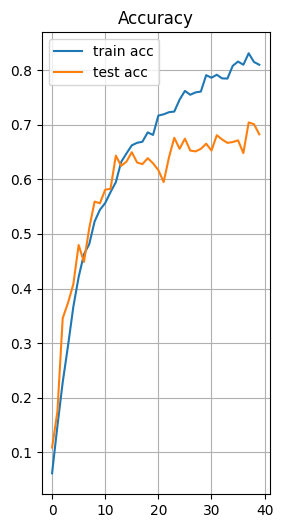

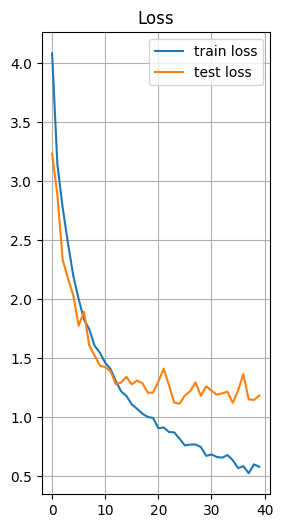

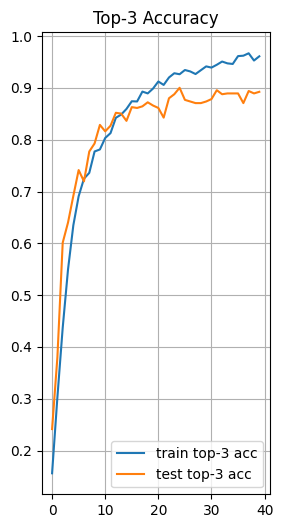

In [37]:
graf('Accuracy', 'train acc', 'test acc', epochs, train_accuracy, test_accuracy)
graf('Loss', 'train loss', 'test loss', epochs, train_loss, test_loss)
graf('Top-3 Accuracy', 'train top-3 acc', 'test top-3 acc', epochs, train_top3_accuracy, test_top3_accuracy)

In [38]:
correct, total = 0, 0

for x, y in test_set:
    y_pred = np.argmax(model.predict(x), axis=1)
    correct_cats = sum([y_pred[i] in class_cats and y[i] in class_cats for i in range(len(y))])
    correct_dogs = sum([y_pred[i] in class_dogs and y[i] in class_dogs for i in range(len(y))])
    correct += correct_cats + correct_dogs
    total += len(y)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


In [39]:
y_real = np.array([])
y_pred = np.array([])

for x, y in test_set:
    y_real = np.concatenate((y_real, y), axis=None)
    y_pred = np.concatenate((y_pred, np.argmax(model.predict(x), axis=1)), axis=None)    

confusion_matrix = tf.math.confusion_matrix(y_real, y_pred, num_classes=len(class_names))
df_cm = pd.DataFrame(confusion_matrix, index = [i for i in class_names], columns = [i for i in class_names])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


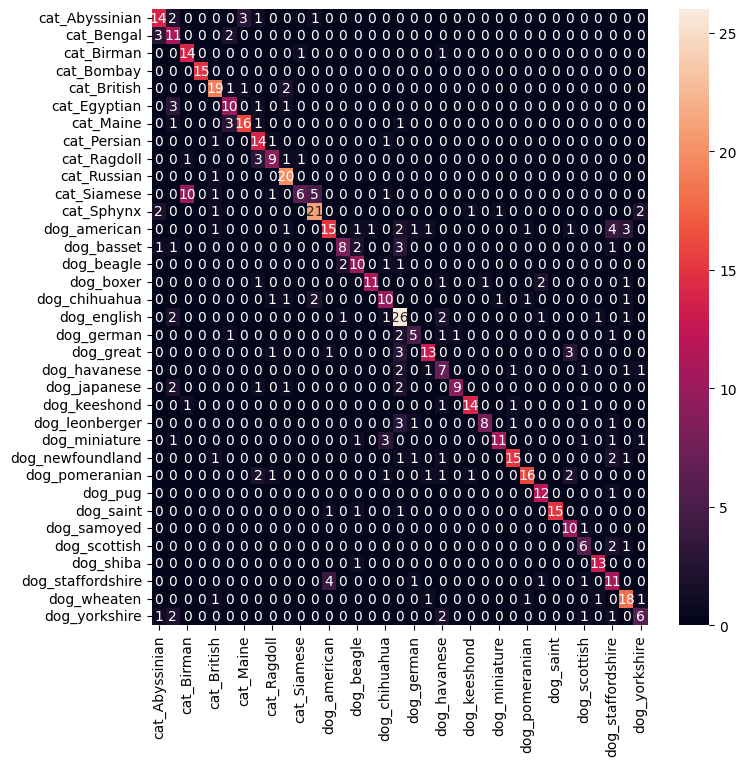

In [40]:
plt.figure(figsize = (8, 8))
sn.heatmap(df_cm, annot=True)
plt.show()

In [41]:
print('\nFinal train accuracy:', train_accuracy[epochs - 1])
print('Final test accuracy:', test_accuracy[epochs - 1])
print('\nFinal train loss:', train_loss[epochs - 1])
print('Final test loss:', test_loss[epochs - 1])
print('\nBinary classification accuracy:', correct / total)
print('\nFinal train top-3 accuracy:', train_top3_accuracy[epochs - 1])
print('Final test top-3 accuracy:', test_top3_accuracy[epochs - 1])
print("\ntime =", end_time - start_time, '\n')


Final train accuracy: 0.8096535801887512
Final test accuracy: 0.6822429895401001

Final train loss: 0.580285370349884
Final test loss: 1.1846113204956055

Binary classification accuracy: 0.9454828660436138

Final train top-3 accuracy: 0.9610743522644043
Final test top-3 accuracy: 0.8925233483314514

time = 629.4359686374664 

